In [10]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv', 'payments'),
    ('order_items.csv','order_items') # Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='Kafi@2025',
    database='ecommerce'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = '/Users/kafi/Desktop/e-Commerce'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing sellers.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Processing products.csv
NaN values before replacement:
product_id                      0
product category              610
product_name_length           610
product_description_length    610
product_photos_qty            610
prod

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import mysql.connector

db=mysql.connector.connect(host='localhost',
    user='root',
    password='Kafi@2025',
    database='ecommerce')

curr=db.cursor()

# 1. List all unique cities where customers are located.

In [7]:
query = """select count(orders.order_id) from ecommerce.orders where year(orders.order_purchase_timestamp)=2017"""

curr.execute(query)

data=curr.fetchall()

data

[(315707,)]

# 2. Count the number of orders placed in 2017.

In [8]:
query = """ select distinct customer_city from customers """

curr.execute(query)

data=curr.fetchall()

data

[('franca',),
 ('sao bernardo do campo',),
 ('sao paulo',),
 ('mogi das cruzes',),
 ('campinas',),
 ('jaragua do sul',),
 ('timoteo',),
 ('curitiba',),
 ('belo horizonte',),
 ('montes claros',),
 ('rio de janeiro',),
 ('lencois paulista',),
 ('caxias do sul',),
 ('piracicaba',),
 ('guarulhos',),
 ('pacaja',),
 ('florianopolis',),
 ('aparecida de goiania',),
 ('santo andre',),
 ('goiania',),
 ('cachoeiro de itapemirim',),
 ('sao jose dos campos',),
 ('sao roque',),
 ('camacari',),
 ('resende',),
 ('sumare',),
 ('novo hamburgo',),
 ('sao luis',),
 ('sao jose',),
 ('santa barbara',),
 ('ribeirao preto',),
 ('ituiutaba',),
 ('taquarituba',),
 ('sao jose dos pinhais',),
 ('barrinha',),
 ('parati',),
 ('dourados',),
 ('trindade',),
 ('cascavel',),
 ('fortaleza',),
 ('brasilia',),
 ('pelotas',),
 ('porto alegre',),
 ('salto',),
 ('jundiai',),
 ('cacapava',),
 ('sao vicente',),
 ('uberlandia',),
 ('botelhos',),
 ('sao goncalo',),
 ('araucaria',),
 ('nova iguacu',),
 ('areia branca',),
 ('campo

# 4. Calculate the percentage of orders that were paid in installments. 

In [14]:
query = """ select (sum(case when payment_installments>0 then 1 else 0 end)/count(*))*100 from payments """

curr.execute(query)

data=curr.fetchall()

data

[(Decimal('100.0000'),)]

# 5. Count the number of customers from each state. 

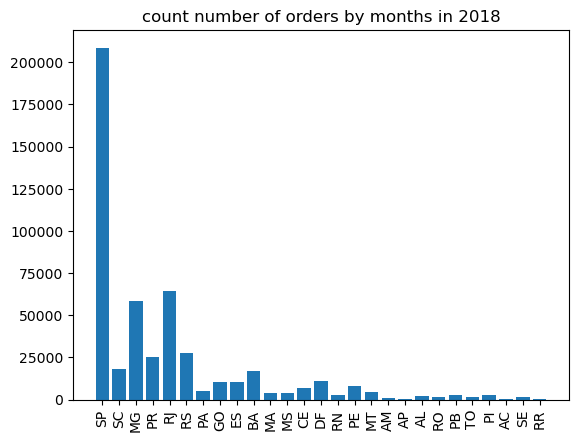

In [32]:
query = """ select customer_state as state,count(customer_id) from customers group by state  """

curr.execute(query)

data=curr.fetchall()

df=pd.DataFrame(data,columns=["state","total_customers"])

df

plt.bar(df["state"],df["total_customers"])

plt.title("count number of orders by months in 2018")

plt.xticks(rotation=90)
plt.show()

# 6. Calculate the number of orders per month in 2018.

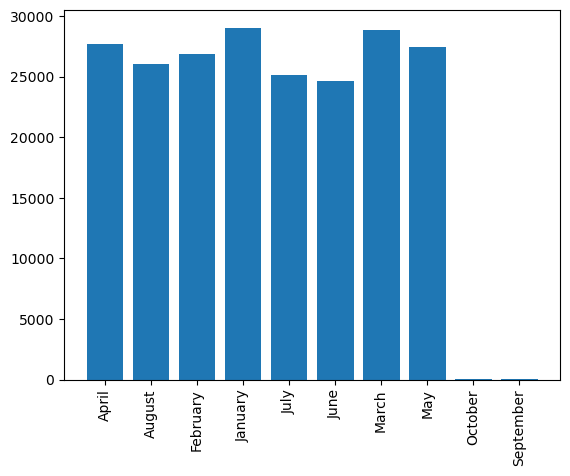

In [30]:
query = """ select monthname(order_purchase_timestamp) as months,count(order_id) as total_orders from orders 
            where year(order_purchase_timestamp)=2018 group by months order by months"""

curr.execute(query)

data=curr.fetchall()

df=pd.DataFrame(data,columns=["months","total_orders"])

df

plt.bar(df["months"],df["total_orders"])

plt.xticks(rotation=90)

plt.show()

# 7. Find the average number of products per order, grouped by customer city.

In [45]:
query = """with count_per_order as (select orders.order_id,orders.customer_id ,count(order_items.order_id) as oc from 
           ecommerce.orders join ecommerce.order_items on orders.order_id=order_items.order_id 
           group by orders.order_id,orders.customer_id ) 
            
            select customers.customer_city as cities,round(avg(count_per_order.oc),2) as avg_products from ecommerce.customers 
            join count_per_order on customers.customer_id=count_per_order.customer_id group by customers.customer_city"""

curr.execute(query)

data=curr.fetchall()

data

df=pd.DataFrame(data,columns=["cities","avg_products"])

df

# plt.bar(df["months"],df["total_orders"])

# plt.xticks(rotation=90)

# plt.show()

,cities,avg_products
0,treze tilias,5.09
1,indaial,4.46
2,sao jose dos campos,4.55
3,sao paulo,4.62
4,porto alegre,4.70
...,...,...
4105,tibau do sul,4.00
4106,sao mamede,4.00
4107,guairaca,8.00
4108,sambaiba,4.00


# 8. Calculate the percentage of total revenue contributed by each product category.

In [10]:
query = """ select upper(product_category) as category,round((sum(payment_value)/(select count(payment_value) from payments))*100,2)
            as sales from products join order_items on
            products.product_id=order_items.product_id join payments on
            payments.order_id=order_items.order_id group by category order by sales desc """

curr.execute(query)

data=curr.fetchall()

data

df=pd.DataFrame(data,columns=["category","sales_percentage"])

df

# plt.bar(df["months"],df["total_orders"])

# plt.xticks(rotation=90)

# plt.show()


,category,sales_percentage
0,BED TABLE BATH,4945.48
1,HEALTH BEAUTY,4786.13
2,COMPUTER ACCESSORIES,4578.09
3,FURNITURE DECORATION,4130.04
4,WATCHES PRESENT,4127.26
...,...,...
69,PC GAMER,6.28
70,HOUSE COMFORT 2,4.94
71,CDS MUSIC DVDS,3.46
72,FASHION CHILDREN'S CLOTHING,2.27


# 9. Identify the correlation between product price and the number of times a product has been purchased.

In [19]:
query = """ select upper(products.product_category) as category,count(order_items.product_id) as num_of_products,
            avg(order_items.price) as avg_price from products join order_items
            on products.product_id=order_items.product_id group by category"""

curr.execute(query)

data=curr.fetchall()

data

df=pd.DataFrame(data,columns=["category","num_of_products","avg_price"])

df

# finding the correlation coeficient between num_of_products and price

arr1=df["num_of_products"]

arr2=df["avg_price"]

np.corrcoef(arr1,arr2)

# our correlation is approx to 0 means neutral hence there has no any effecct on each others

array([[ 1.        , -0.10631552],
       [-0.10631552,  1.        ]])

# 10. Calculate the total revenue generated by each seller, and rank them by revenue.

In [5]:
query = """ select *,dense_rank() over(order by revenue desc) as rn from 
            (select seller_id,round(sum(payment_value),2) as revenue from order_items join
             payments on order_items.order_id=payments.order_id group by seller_id) as a"""

curr.execute(query)

data=curr.fetchall()

data

df=pd.DataFrame(data,columns=["seller_id","revenue","rank"])

df
 

,seller_id,revenue,rank
0,7c67e1448b00f6e969d365cea6b010ab,12679172.68,1
1,1025f0e2d44d7041d6cf58b6550e0bfa,7705551.00,2
2,4a3ca9315b744ce9f8e9374361493884,7531131.74,3
3,1f50f920176fa81dab994f9023523100,7256335.50,4
4,53243585a1d6dc2643021fd1853d8905,7122577.01,5
...,...,...,...
3090,ad14615bdd492b01b0d97922e87cb87f,480.25,3076
3091,702835e4b785b67a084280efca355756,464.00,3077
3092,4965a7002cca77301c82d3f91b82e1a9,409.00,3078
3093,77128dec4bec4878c37ab7d6169d6f26,380.50,3079


# 11. Calculate the cumulative sales per month for each year.

In [46]:
query = """ select years ,months,sum(payment) over(order by years,months) from 
            (select year(orders.order_purchase_timestamp) as years,
            monthname(orders.order_purchase_timestamp) as months ,
            round(sum(payment_value),2) as payment from orders join payments 
            on orders.order_id=payments.order_id group by years,months ) as a"""

curr.execute(query)

data=curr.fetchall()

data

df=pd.DataFrame(data,columns=["years","months","cumsum"])

df


,years,months,cumsum
0,2016,December,78.48
1,2016,October,236440.40
2,2016,September,237449.36
3,2017,April,1908601.48
4,2017,August,4606186.76
5,2017,December,8119792.68
6,2017,February,9287424.72
7,2017,January,9841376.88
8,2017,July,12210908.56
9,2017,June,14256014.08


# 12. Calculate the year-over-year growth rate of total sales.

In [55]:
query = """ select year(orders.order_purchase_timestamp) as years,
            round(sum(payment_value),2) as total_sales from orders join payments 
            on orders.order_id=payments.order_id group by years order by years"""

curr.execute(query)

data=curr.fetchall()

data

df=pd.DataFrame(data,columns=["years","total_sales"])

df

# plt.bar(df["years"],df["total_sales"]) 

# plt.show()


,years,total_sales
0,2016,237449.36
1,2017,28998986.91
2,2018,34799052.21


# 13. Identify the top 3 customers who spent the most money in each year.

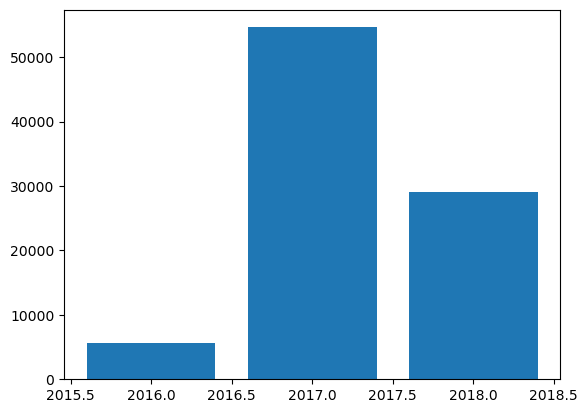

In [69]:
query = """select * from (select year(orders.order_purchase_timestamp) as years,customer_id,
            round(sum(payment_value),2) as total_sales,dense_rank() over(partition by  year(orders.order_purchase_timestamp)
            order by round(sum(payment_value),2) desc) as d_rank
            from orders join payments 
            on orders.order_id=payments.order_id group by years,customer_id ) as a 
            where d_rank<=3 """

curr.execute(query)

data=curr.fetchall()

data

df=pd.DataFrame(data,columns=["years","id","total_sales","rank"])

df

plt.bar(df["customer_id"],df["total_sales"]) 

plt.show()


# 14. Calculate the moving average of order values for each customer over their order history.

In [ ]:
query = """ select customer_id,order_purchase_timestamp,avg(payment) over(partition by customer_id order by order_purchase_timestamp rows 
            between 2 preceding and current row) as mov_avg from 
            (select customer_id,order_purchase_timestamp,round(payment_value,2) as payment from orders join payments on
            orders.order_id=payments.order_id) as a"""

curr.execute(query)

data=curr.fetchall()

data

df=pd.DataFrame(data,columns=["customer_id","duration","mov_avg"])

df

# plt.bar(df["customer_id"],df["total_sales"]) 

# plt.show()
